<a href="https://colab.research.google.com/github/ravikarora/Kabiurr-Task_6/blob/main/multi_class_text_classification_tfidf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification (multiclass)

# Table of Content

* [Goal](#obj)
* [Importing packages and loading data](#imp)
* [Exploratory Data Analysis (EDA) and Feature Engineering](#eda)
* [Text Preprocessing](#pre)
* [Multi-Classification models](#ml)
    * [Spliting the data: train and test](#sp)
    * [Models](#m)
* [Comparison of model performance](#sum)
* [Model Evaluation](#ev)
    * [Precision, Recall, F1-score](#f1)
    * [Confusion Matrix](#cm)
* [Predictions](#pred)

<a id='imp'></a>
## Importing packages and loading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics


In [ ]:

df = pd.read_csv('/content/drive/MyDrive/rows4.csv')
df.shape

<ipython-input-8-9b89df7353ef>:2: DtypeWarning: Columns (4,5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/rows4.csv')


(1282355, 18)

We have more than 1 million instances (rows) and 18 features (columns).

<a id='eda'></a>
## Exploratory Data Analysis (EDA) and Feature Engineering

In [ ]:
df.head(2)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,05/10/2019,Checking or savings account,Checking account,Managing an account,Problem using a debit or ATM card,NaN,NaN,NAVY FEDERAL CREDIT UNION,FL,328XX,Older American,NaN,Web,05/10/2019,In progress,Yes,NaN,3238275
1,05/10/2019,Checking or savings account,Other banking product or service,Managing an account,Deposits and withdrawals,NaN,NaN,BOEING EMPLOYEES CREDIT UNION,WA,98204,NaN,NaN,Referral,05/10/2019,Closed with explanation,Yes,NaN,3238228


In [ ]:
df.head(2).T

,0,1
Date received,05/10/2019,05/10/2019
Product,Checking or savings account,Checking or savings account
Sub-product,Checking account,Other banking product or service
Issue,Managing an account,Managing an account
Sub-issue,Problem using a debit or ATM card,Deposits and withdrawals
Consumer complaint narrative,NaN,NaN
Company public response,NaN,NaN
Company,NAVY FEDERAL CREDIT UNION,BOEING EMPLOYEES CREDIT UNION
State,FL,WA
ZIP code,328XX,98204


In [ ]:
df1 = df[['Product', 'Consumer complaint narrative']].copy()

df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]


df1.columns = ['Product', 'Consumer_complaint']

df1.shape

(383564, 2)

In [ ]:
df1.head()

,Product,Consumer_complaint
29904,"Credit reporting, credit repair services, or o...",The Summer of XX/XX/2018 I was denied a mortga...
30629,"Credit reporting, credit repair services, or o...",There are many mistakes appear in my report wi...
30735,"Credit reporting, credit repair services, or o...",There are many mistakes appear in my report wi...
30795,"Credit reporting, credit repair services, or o...",There are many mistakes appear in my report wi...
30807,"Credit reporting, credit repair services, or o...",There are many mistakes appear in my report wi...


In [ ]:
total = df1['Consumer_complaint'].notnull().sum()
round((total/len(df)*100),1)

29.9

From more than 1 million complaints, there are about 380,000 cases with text (~ 30% of the original dataset is not null). This is still a good number to work with. Now let's have a look at the categories we want to classify each complaint.

In [ ]:
pd.DataFrame(df.Product.unique()).values

array([['Checking or savings account'],
       ['Debt collection'],
       ['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Mortgage'],
       ['Student loan'],
       ['Vehicle loan or lease'],
       ['Credit card or prepaid card'],
       ['Payday loan, title loan, or personal loan'],
       ['Money transfer, virtual currency, or money service'],
       ['Credit reporting'],
       ['Credit card'],
       ['Bank account or service'],
       ['Consumer Loan'],
       ['Prepaid card'],
       ['Other financial service'],
       ['Payday loan'],
       ['Money transfers'],
       ['Virtual currency']], dtype=object)

In [ ]:
df2 = df1.sample(10000, random_state=1).copy()

In [ ]:
df2.replace({'Product':
             {'Credit reporting, credit repair services, or other personal consumer reports':
              'Credit reporting, repair, or other',
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}},
            inplace= True)

In [ ]:
pd.DataFrame(df2.Product.unique())

,0
0,"Credit reporting, repair, or other"
1,Debt collection
2,Consumer Loan
3,Credit card or prepaid card
4,Mortgage
5,Vehicle loan or lease
6,Student loan
7,"Payday loan, title loan, or personal loan"
8,Checking or savings account
9,Bank account or service


In [ ]:
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()

category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

df2.head()

,Product,Consumer_complaint,category_id
310399,"Credit reporting, repair, or other",Bayview completely ignored laws and is reporti...,0
186155,"Credit reporting, repair, or other",inaccurate information no knowledge of account...,0
651135,Debt collection,On XXXX/XXXX/2016 I received a notice from Con...,1
515233,Consumer Loan,I have a loan with Kia Motor Finance. I rece...,2
641112,Credit card or prepaid card,I have a XXXX BIG card and made my payment whe...,3


The bar chart below shows the number of complaints per category. It can be observed that The bar chart below shows the number of complaints per category. It can be observed that most of customer complaints are due to:
* credit reporting, credit repair
* debt collection
* mortgage

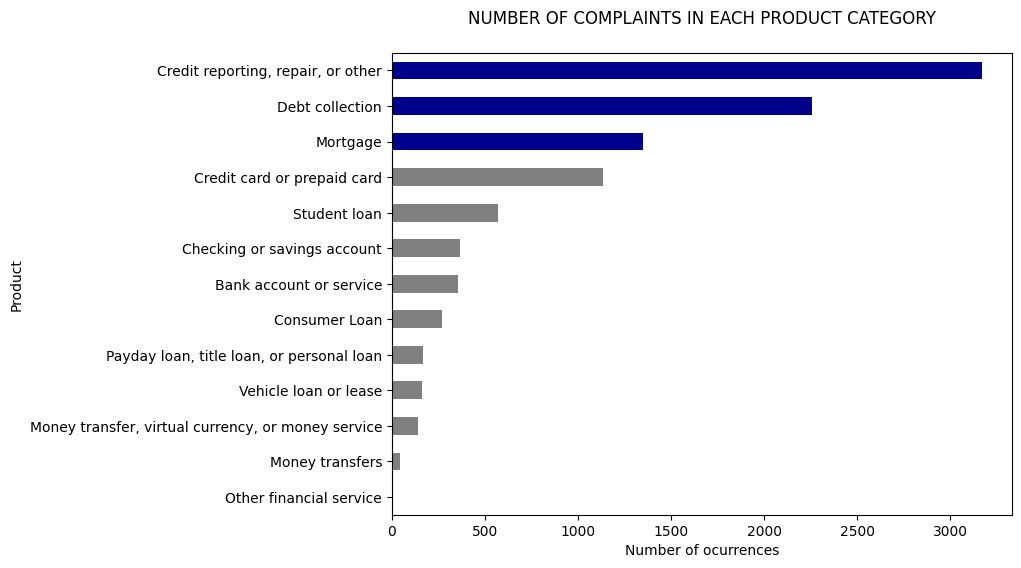

In [ ]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

<a id='pre'></a>
## Text Preprocessing

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 27507 features (TF-IDF score of unigrams and bigrams)


In [ ]:

N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Product))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Bank account or service:
  * Most Correlated Unigrams are: overdraft, bank, scottrade
  * Most Correlated Bigrams are: citigold checking, debit card, checking account

==> Checking or savings account:
  * Most Correlated Unigrams are: checking, branch, overdraft
  * Most Correlated Bigrams are: 00 bonus, overdraft fees, checking account

==> Consumer Loan:
  * Most Correlated Unigrams are: dealership, vehicle, car
  * Most Correlated Bigrams are: car loan, vehicle loan, regional acceptance

==> Credit card or prepaid card:
  * Most Correlated Unigrams are: express, citi, card
  * Most Correlated Bigrams are: balance transfer, american express, credit card

==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: report, experian, equifax
  * Most Correlated Bigrams are: credit file, equifax xxxx, credit report

==> Debt collection:
  * Most Correlated Unigrams are: collect, collection, debt
  * Most Correlated Bigrams are: debt collector, collect debt, collection 

<a id='ml'></a>
## Multi-Classification models

The classification models evaluated are:
* Random Forest
* Linear Support Vector Machine
* Multinomial Naive Bayes
* Logistic Regression.

<a id='sp'></a>
### Spliting the data into train and test sets

In [ ]:
X = df2['Consumer_complaint']
y = df2['Product']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

<a id='m'></a>
### Models

In [ ]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

<a id='sum'></a>
## Comparison of model performance

The best mean acuracy was obtained with LinearSVC.

In [ ]:
cv_df.head()

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.3940
1,RandomForestClassifier,1,0.4025
2,RandomForestClassifier,2,0.3885
3,RandomForestClassifier,3,0.4010
4,RandomForestClassifier,4,0.3885


In [ ]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1,
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.7791,0.005561
LogisticRegression,0.7641,0.009839
MultinomialNB,0.6475,0.004596
RandomForestClassifier,0.3949,0.006665


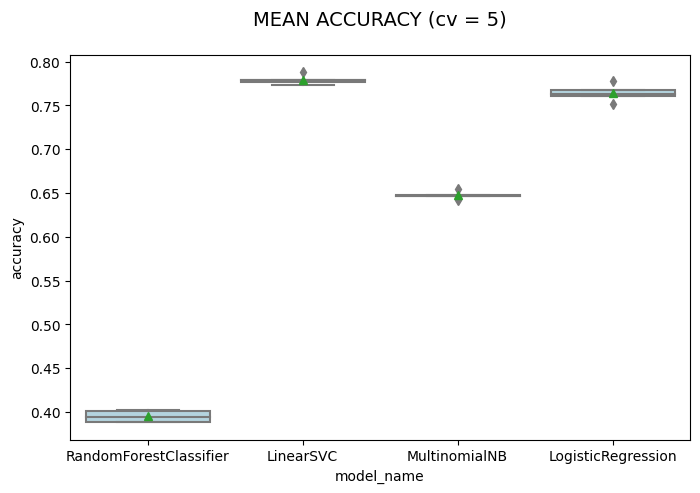

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy',
            data=cv_df,
            color='lightblue',
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

<a id='ev'></a>
## Model Evaluation

In [ ]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features,
                                                               labels,
                                                               df2.index, test_size=0.25,
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

<a id='m'></a>
### Precision, Recall, F1-score

In [ ]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred,
                                    target_names= df2['Product'].unique()))

				CLASSIFICATIION METRICS

                                                    precision    recall  f1-score   support

                Credit reporting, repair, or other       0.81      0.88      0.84       783
                                   Debt collection       0.76      0.80      0.78       588
                                     Consumer Loan       0.52      0.22      0.31        73
                       Credit card or prepaid card       0.73      0.82      0.77       253
                                          Mortgage       0.87      0.92      0.90       340
                             Vehicle loan or lease       0.43      0.14      0.21        43
                                      Student loan       0.85      0.85      0.85       155
         Payday loan, title loan, or personal loan       0.50      0.17      0.26        40
                       Checking or savings account       0.61      0.60      0.61        85
                           Bank account or service

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<a id='cm'></a>
### Confusion Matrix


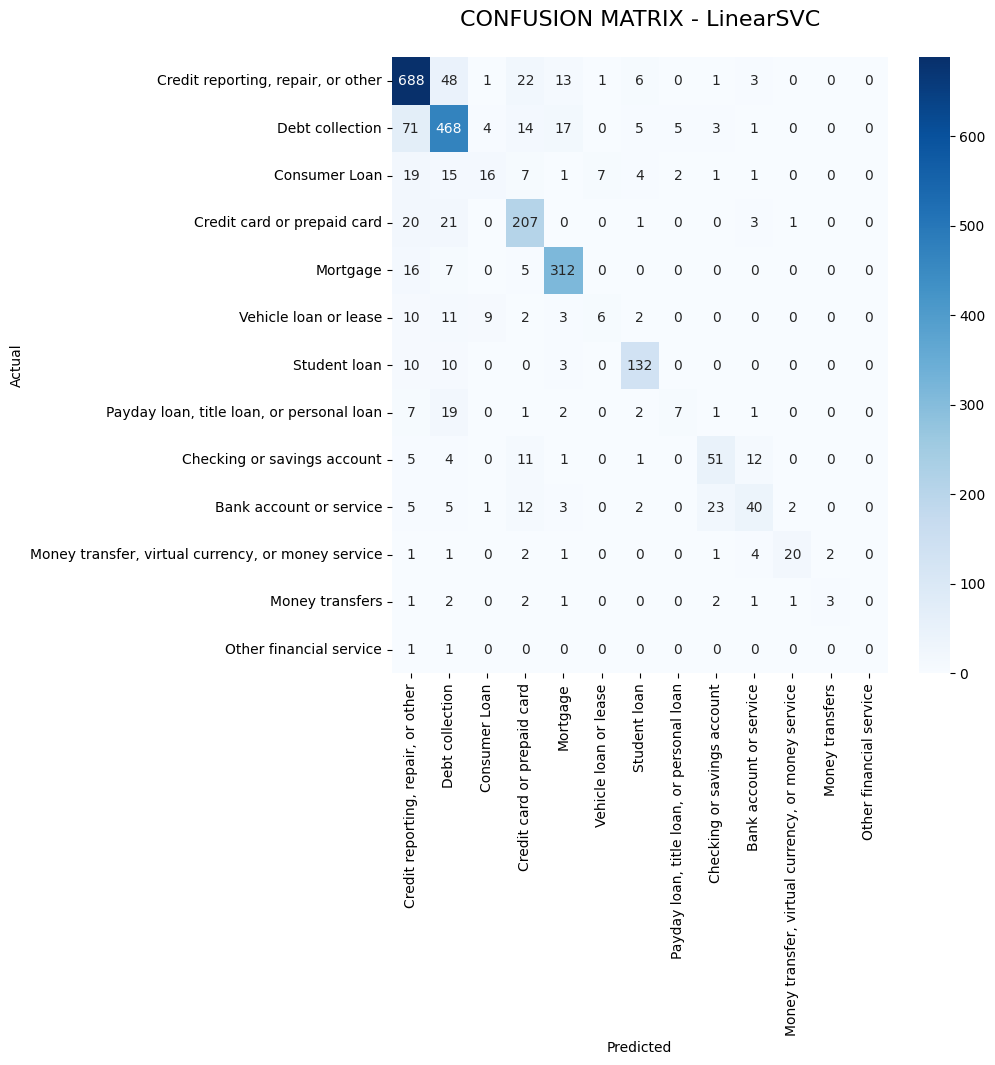

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values,
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);



#### Misclassified complaints


In [ ]:
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 20:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual],
                                                           id_to_category[predicted],
                                                           conf_mat[actual, predicted]))

            display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product',
                                                                'Consumer_complaint']])
            print('')

'Debt collection' predicted as 'Credit reporting, repair, or other' : 71 examples.


,Product,Consumer_complaint
483075,Debt collection,This agency has three collections listed which...
111807,Debt collection,I am writing to dispute the inaccurate data be...
376788,Debt collection,check n ' Go payday loan made me a loan and th...
570764,Debt collection,THIS AMT OWED {$8800.00} WAS TO BE PAID UNDER ...
88089,Debt collection,I am submitting this complaint for an account ...
...,...,...
155139,Debt collection,"Between XX/XX/XXXX and XX/XX/XXXX, this accoun..."
360018,Debt collection,"On XXXX XXXX, 2017 XXXX opened up an account f..."
165296,Debt collection,I have tried disputing with the bureau on seve...
159609,Debt collection,This is a complaint against National Credit Sy...



'Credit card or prepaid card' predicted as 'Credit reporting, repair, or other' : 20 examples.


,Product,Consumer_complaint
399397,Credit card or prepaid card,"On XXXX XXXX, XXXX I submitted correspondence ..."
752303,Credit card or prepaid card,I purchased a room size air conditioner from X...
544109,Credit card or prepaid card,To Whom May Concern : Early Spring XX/XX/XXXX ...
723669,Credit card or prepaid card,The Sychrony issued excessive credit to me thr...
202661,Credit card or prepaid card,I reviewed my credit report and saw an account...
891797,Credit card or prepaid card,I have a SYNCB/WALMART DUAL CARD. Unbeknownst ...
280866,Credit card or prepaid card,XX/XX/2017 Monthly payment XXXX dollars. I rea...
350390,Credit card or prepaid card,I received a letter from XXXX On XXXX XXXX 201...
413596,Credit card or prepaid card,"XXXX investigated the following listing, XXXX ..."
725609,Credit card or prepaid card,Seventh Ave has charged off an account and con...



'Credit reporting, repair, or other' predicted as 'Debt collection' : 48 examples.


,Product,Consumer_complaint
167717,"Credit reporting, repair, or other",When my vehicle was repossessed in XX/XX/2017 ...
131925,"Credit reporting, repair, or other",I submitted a dispute online on a debt with XX...
675868,"Credit reporting, repair, or other",My name is XXXX XXXX. Your collection agency i...
370575,"Credit reporting, repair, or other",Credit reporting agency incorrectly keeps repo...
863037,"Credit reporting, repair, or other",This medical bill was paid to another collecto...
597294,"Credit reporting, repair, or other","I received a call, and my oldest daughter got ..."
301509,"Credit reporting, repair, or other",While attempting to get approval for a loan to...
404336,"Credit reporting, repair, or other",On XX/XX/XXXX I sent a letter to Wakefield & A...
310415,"Credit reporting, repair, or other","Portfolio Recov Assoc, Promise to remove the c..."
347164,"Credit reporting, repair, or other",XXXX Inquired because someone is trying to use...



'Credit card or prepaid card' predicted as 'Debt collection' : 21 examples.


,Product,Consumer_complaint
427835,Credit card or prepaid card,XXXX would not honor an offer to credit {$50.0...
468331,Credit card or prepaid card,hi I 'm on payment program with American expre...
36821,Credit card or prepaid card,"I am corresponding about my XXXX XXXX XXXX, wh..."
681770,Credit card or prepaid card,I sent the following message to Capital One on...
859065,Credit card or prepaid card,I had several attempts to get information abou...
504540,Credit card or prepaid card,This is in regards to BOTH a Total Visa acco...
872562,Credit card or prepaid card,I used a debt relief agency to pay my debts ( ...
609682,Credit card or prepaid card,I have a letter stating from American Express ...
907179,Credit card or prepaid card,I keep getting a robo call ( XXXX ) threatenin...
517845,Credit card or prepaid card,Bank of America is refusing to produce proof o...



'Credit reporting, repair, or other' predicted as 'Credit card or prepaid card' : 22 examples.


,Product,Consumer_complaint
184965,"Credit reporting, repair, or other",XXXX is a company of XXXX and XXXX XXXX up my...
846410,"Credit reporting, repair, or other",There is incorrect credit card showing up on m...
192020,"Credit reporting, repair, or other",I went to the Capital One web site to apply fo...
265650,"Credit reporting, repair, or other",XXXX XXXX XXXX reported my account as charged ...
301997,"Credit reporting, repair, or other","XXXX Barclay , XXXX and XXXX are not updating ..."
473355,"Credit reporting, repair, or other",Company : USAA Summary of events : About XXXX ...
257154,"Credit reporting, repair, or other",I had an automatic payment of {$50.00} schedul...
168845,"Credit reporting, repair, or other",It percieved XXXX and other credit reporting a...
421206,"Credit reporting, repair, or other",Unable to get by bots or reach by telephone. C...
49300,"Credit reporting, repair, or other",In XX/XX/XXXX I needed a credit card to use to...



'Bank account or service' predicted as 'Checking or savings account' : 23 examples.


,Product,Consumer_complaint
655179,Bank account or service,My email is XXXXXXXXXXXX and I never got to pr...
540543,Bank account or service,HSBC refuses to confirm the date my account wa...
655963,Bank account or service,Bank of America has charged me numerous XXXX f...
593920,Bank account or service,My complaint is with Capital One 360 ; they do...
692350,Bank account or service,"My name is XXXX, I am my father 's heir & the ..."
760899,Bank account or service,I have a XXXX IRA with Capital One 360. My mob...
674009,Bank account or service,"On XXXX XXXX 2016, I 'd visited the Wells Farg..."
541558,Bank account or service,On XXXX my husband deposited {$400.00} through...
547387,Bank account or service,"On XX/XX/XXXX, a merchant presented an electro..."
816633,Bank account or service,On XXXX I deposited an insurance claim check (...


#### Most correlated terms with each category

In [ ]:
model.fit(features, labels)

N = 4
for Product, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("\n==> '{}':".format(Product))
    print("  * Top unigrams: %s" %(', '.join(unigrams)))
    print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'Bank account or service':
  * Top unigrams: bank, scottrade, deposit, suntrust
  * Top bigrams: bank xxxx, check account, debit card, xx 2016

==> 'Checking or savings account':
  * Top unigrams: bank, transactions, bonus, branch
  * Top bigrams: debit card, xxxx 2017, overdraft fees, account information

==> 'Consumer Loan':
  * Top unigrams: car, furniture, title, loan
  * Top bigrams: vehicle loan, lien release, regional acceptance, xxxx constantly

==> 'Credit card or prepaid card':
  * Top unigrams: card, capital, citi, amex
  * Top bigrams: american express, use card, balance transfer, annual fee

==> 'Credit reporting, repair, or other':
  * Top unigrams: equifax, experian, transunion, report
  * Top bigrams: xxxx reported, equifax xxxx, xxxx xxxx, trans union

==> 'Debt collection':
  * Top unigrams: debt, collection, collections, owe
  * Top bigrams: credit services, trying collect, violation knowledge, account credit

==> 'Money transfer, virtual currency, or money serv

<a id='pred'></a>
## Predictions

In [ ]:
X.head()

310399    Bayview completely ignored laws and is reporti...
186155    inaccurate information no knowledge of account...
651135    On XXXX/XXXX/2016 I received a notice from Con...
515233    I have a loan with  Kia Motor Finance. I  rece...
641112    I have a XXXX BIG card and made my payment whe...
Name: Consumer_complaint, dtype: object

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [ ]:
new_complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Student loan']


The algorithm has classified this text as a "Student loan" complaint.

In [ ]:
df2[df2['Consumer_complaint'] == new_complaint]

,Product,Consumer_complaint,category_id
877489,Student loan,I have been enrolled back at XXXX XXXX Univers...,6


Our model was correct, the complaint was about **Student Loan**.
Let's check another example.

In [ ]:
new_complaint_2 = """Equifax exposed my personal information without my consent, as part of their recent data breach. \
In addition, they dragged their feet in the announcement of the report, and even allowed their upper management to sell \
off stock before the announcement."""
print(model.predict(fitted_vectorizer.transform([new_complaint_2])))

['Credit reporting, repair, or other']


In [ ]:
df2[df2['Consumer_complaint'] == new_complaint_2]

,Product,Consumer_complaint,category_id
420821,"Credit reporting, repair, or other",Equifax exposed my personal information withou...,0


 the algorithm correctly classified the caomplaint as __"Credit reporting, repair, or other"__. Note that this customer has used terms with high TFIDF score, such us __equifax, report__. <br><br>
Although our model is not going to be all the time correct when classifying new complaints, it does a good job.